In [209]:
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

#opening data
import os
import pathlib
import warnings
from joblib import load

# modelling
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#used for plots
from itertools import combinations_with_replacement
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [271]:
#load data - store it in train dataframe
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', 'events_Italy.json') # delete
with open(path) as f: # delete #
    data = json.load(f) # delete #
train = pd.DataFrame(data) # delete #
    
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647231 entries, 0 to 647371
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       647231 non-null  int64  
 1   subEventName  647231 non-null  object 
 2   tags          647231 non-null  object 
 3   playerId      647231 non-null  int64  
 4   positions     647231 non-null  object 
 5   matchId       647231 non-null  int64  
 6   eventName     647231 non-null  object 
 7   teamId        647231 non-null  int64  
 8   matchPeriod   647231 non-null  object 
 9   eventSec      647231 non-null  float64
 10  subEventId    647231 non-null  object 
 11  id            647231 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 64.2+ MB


In [4]:
train['eventName'].unique()

array(['Pass', 'Duel', 'Foul', 'Free Kick', 'Shot', 'Save attempt',
       'Others on the ball', 'Interruption', 'Goalkeeper leaving line',
       'Offside'], dtype=object)

In [5]:
train['subEventName'].unique()

array(['Simple pass', 'High pass', 'Head pass', 'Air duel',
       'Ground loose ball duel', 'Smart pass', 'Launch',
       'Ground defending duel', 'Ground attacking duel', 'Foul',
       'Free Kick', 'Cross', 'Shot', 'Reflexes', 'Touch', 'Clearance',
       'Ball out of the field', 'Throw in', 'Goal kick', 'Corner',
       'Goalkeeper leaving line', 'Hand pass', 'Acceleration',
       'Save attempt', '', 'Free kick cross', 'Free kick shot',
       'Hand foul', 'Violent Foul', 'Protest', 'Whistle',
       'Out of game foul', 'Late card foul', 'Penalty', 'Time lost foul',
       'Simulation'], dtype=object)

In [6]:
train['tags']

0                                            [{'id': 1801}]
1                                            [{'id': 1801}]
2                                            [{'id': 1801}]
3                                            [{'id': 1801}]
4                                            [{'id': 1801}]
                                ...                        
643145                                                   []
643146             [{'id': 302}, {'id': 801}, {'id': 1801}]
643147                          [{'id': 701}, {'id': 1802}]
643148                          [{'id': 703}, {'id': 1801}]
643149    [{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...
Name: tags, Length: 643032, dtype: object

In [272]:
df = pd.DataFrame()
file_name = 'possession_chains_Italy.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)
# df = df.reset_index()

In [273]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#1 variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df[c]
        #create a new column in df
        df[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df.head(3)

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,x1x1x1,x1x1c0,x1x1c1,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1
0,0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,...,92039.290875,2772.3906,8317.1718,83.50944,250.52832,751.58496,2.515456,7.546368,22.639104,67.917312
1,1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,...,54010.152000,5829.6672,32063.1696,629.23392,3460.78656,19034.32608,67.917312,373.545216,2054.498688,11299.742784
2,2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,...,549353.259000,150518.7684,27367.0488,41241.03984,7498.37088,1363.34016,11299.742784,2054.498688,373.545216,67.917312


In [274]:
#predict if ended with shot
duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
X1 = duels[var].values
y1 = duels["shot_end"].values

#path to saved model
path_model = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'models', 'xgb_def_duels_model_Germany.pkl')
xgb_model = load(path_model)

#predict probability of shot ended
y_pred_shot = xgb_model.predict(X1)
duels["shot_prob"] = y_pred_shot

#OLS
shot_ended = duels.loc[duels["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)

#predict probability of goal being scored
y_pred_goal = lr.predict(X1)
duels["xG_pred"] = y_pred_goal

#calculate xGchain
duels["xT"] = duels["shot_prob"] * duels["xG_pred"]
duels[["shot_prob", "xG_pred", "xT"]].head(5)

,shot_prob,xG_pred,xT
78,0.010955,0.157487,0.001725
193,0.014388,0.158082,0.002275
194,0.016171,0.094795,0.001533
361,-0.000719,0.131464,-0.000095
498,0.405946,0.167941,0.068175


In [275]:
xT_duels = duels[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()

In [276]:
xT_duels

,playerId,xT
0,0,1.987223
1,45,0.002687
2,114,0.133947
3,122,-0.396562
4,130,0.019260
...,...,...
463,454457,-0.022644
464,481329,0.000490
465,485464,0.001145
466,491409,0.021175


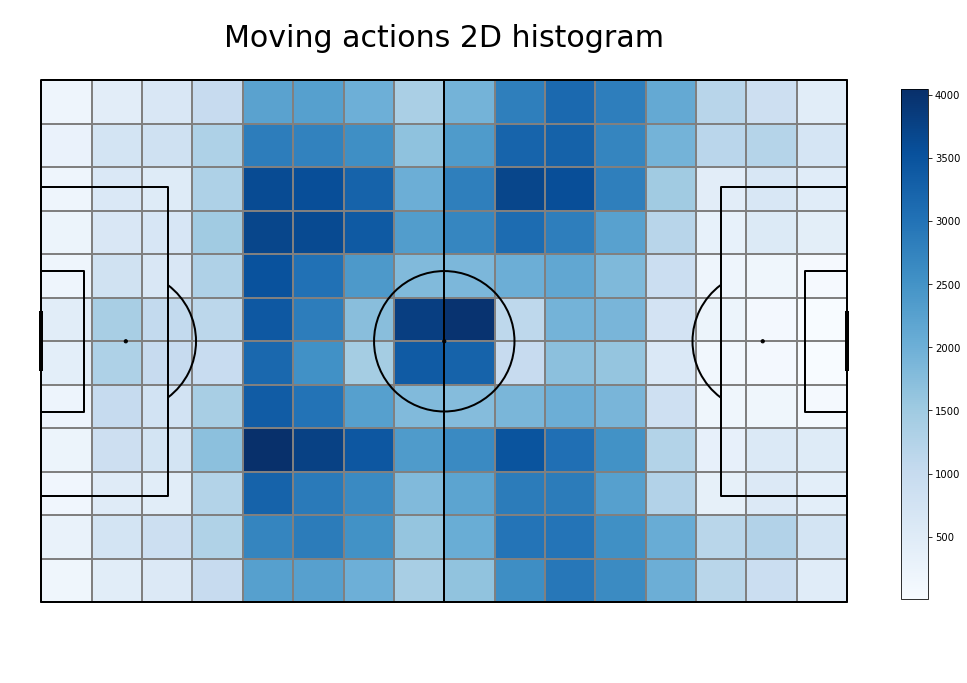

In [277]:
next_event = train.shift(-1, fill_value=0)
train["nextEvent"] = next_event["subEventName"]
train["nextPlayerId"] = next_event["playerId"]
train["nextTeamId"] = next_event["teamId"]

train["kickedOut"] = train.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
move_df = train.loc[train['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

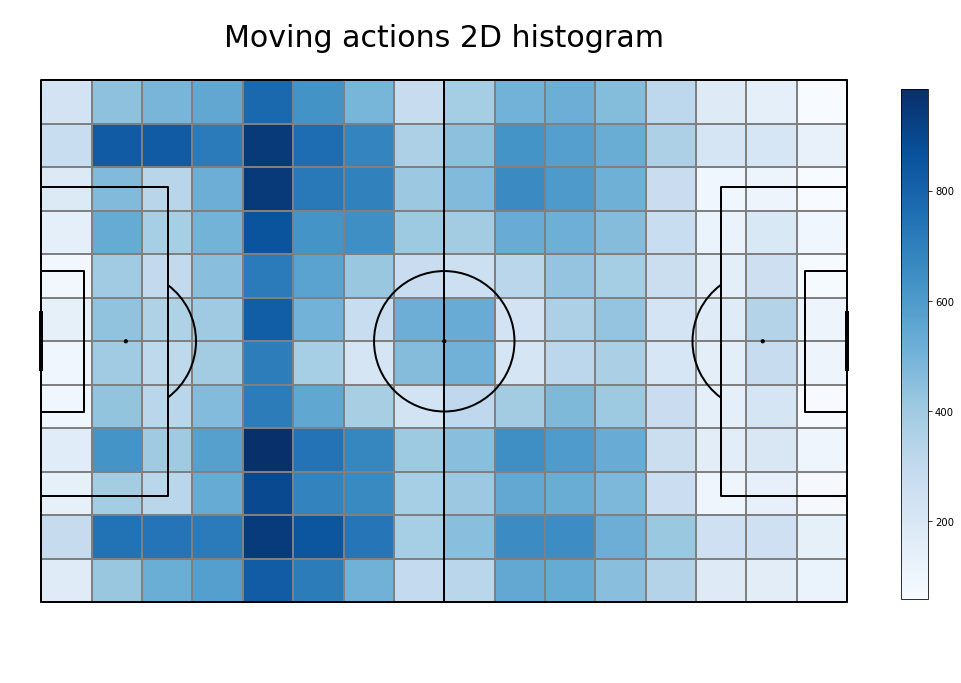

In [278]:
next_event = train.shift(-1, fill_value=0)
train["nextEvent"] = next_event["subEventName"]
train["nextPlayerId"] = next_event["playerId"]
train["nextTeamId"] = next_event["teamId"]

train["kickedOut"] = train.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
# move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
move_df = train.loc[train['subEventName'].isin(['Ground defending duel', 'Ground loose ball duel'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

# filter out actions for the middle 3rd only
# move_df = move_df.loc[(move_df["x"] < 2*105/3) & (move_df["x"] > 105/3)]

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

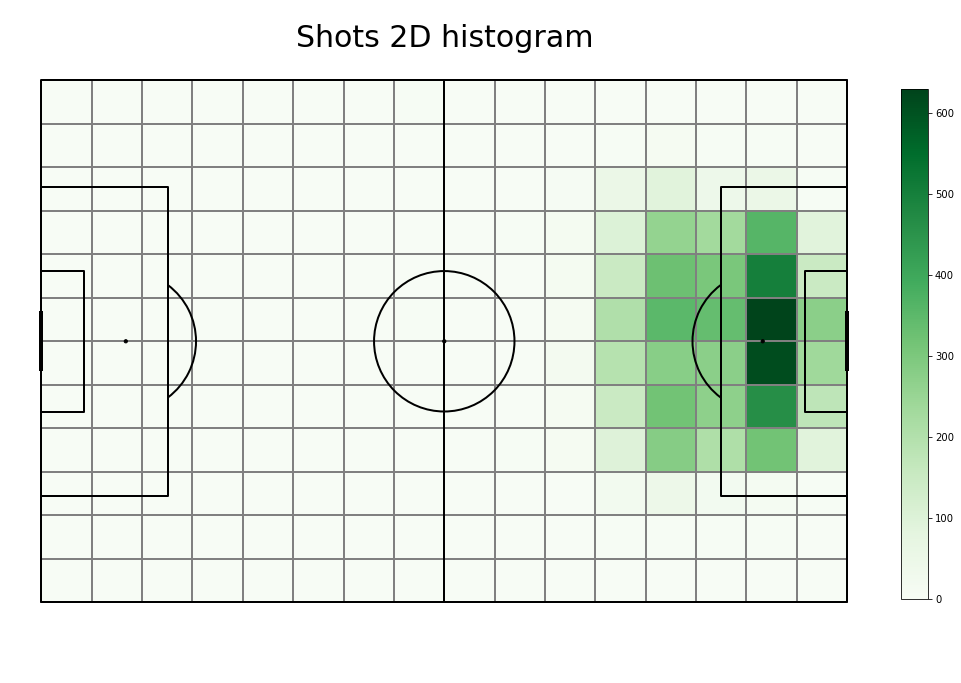

In [279]:
#get shot df
shot_df = train.loc[train['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

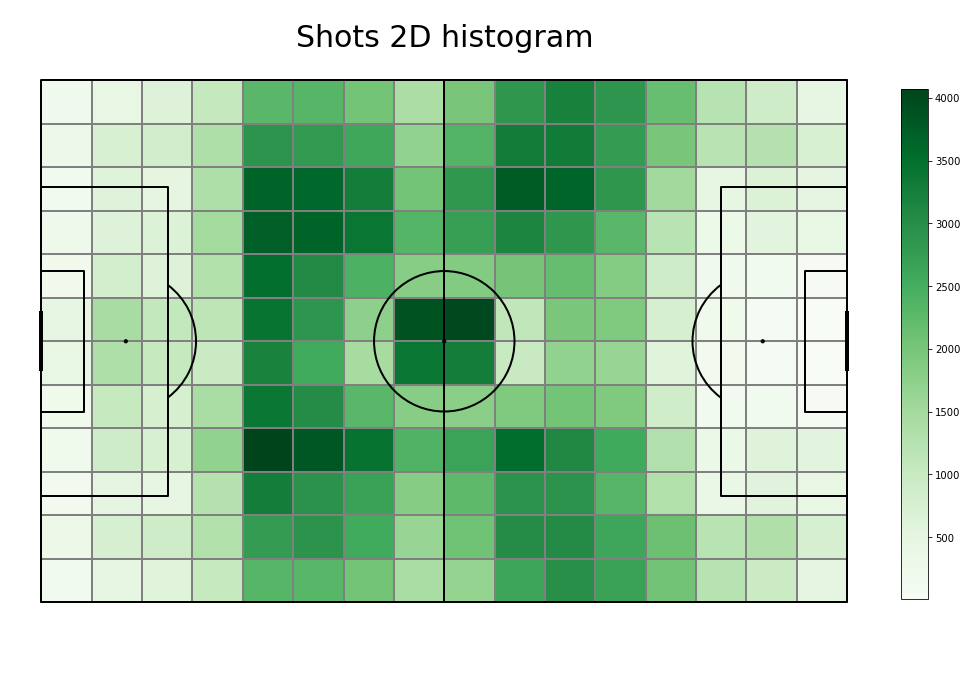

In [280]:
#get shot df
# shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df = train.loc[train['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

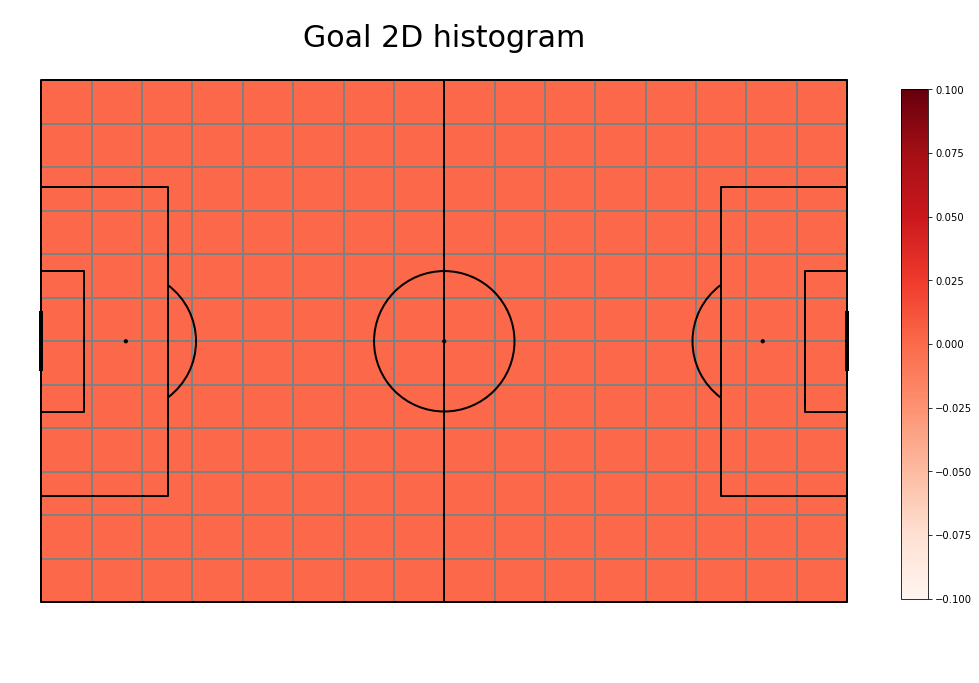

In [281]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

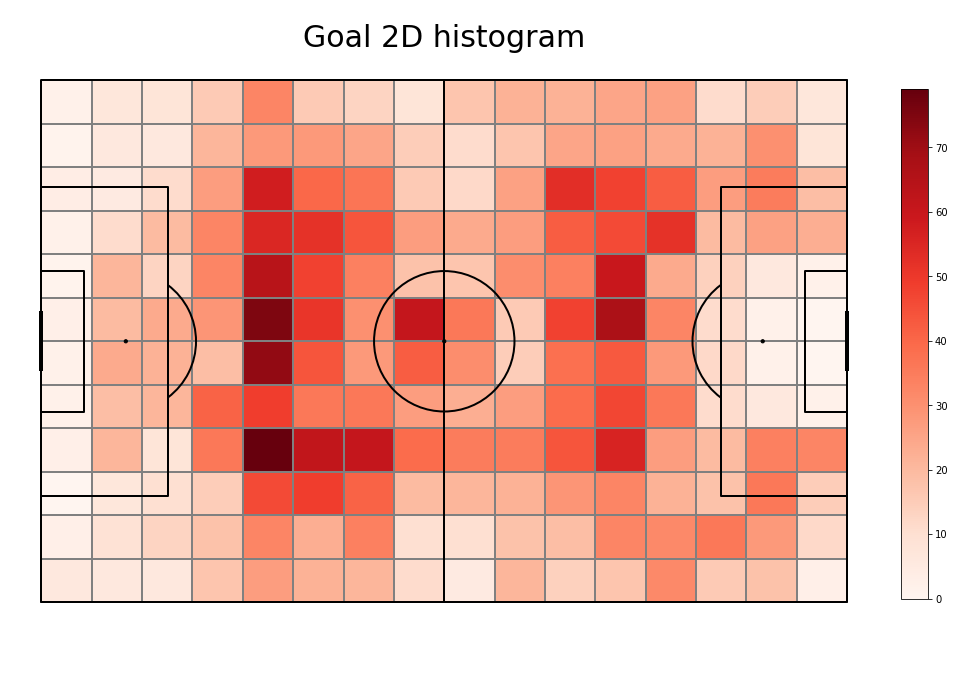

In [12]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':1901} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

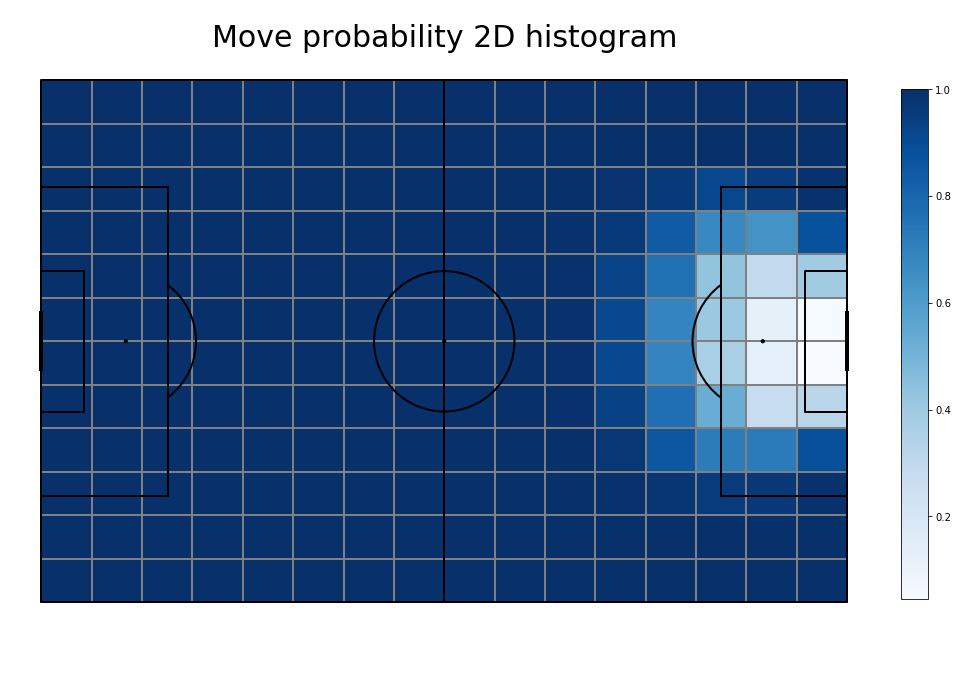

In [33]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

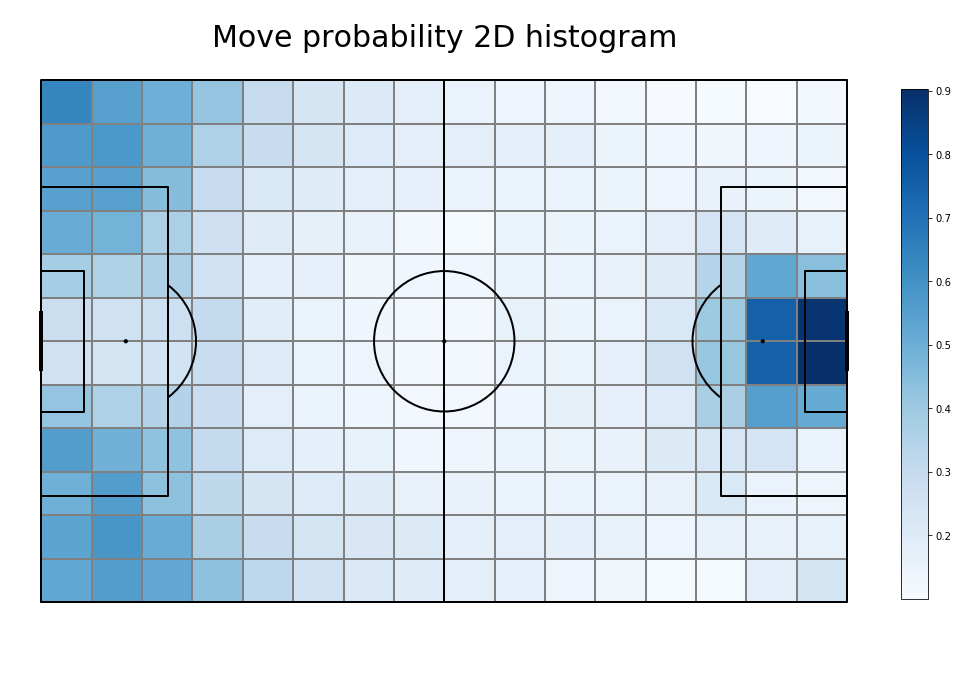

In [13]:
move_probability = move_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

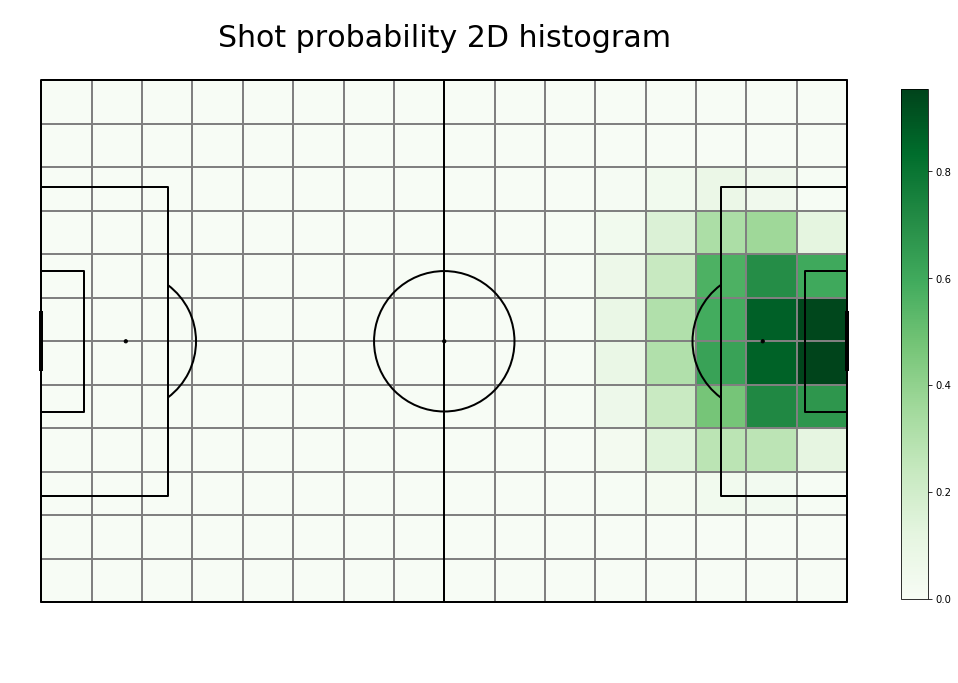

In [34]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

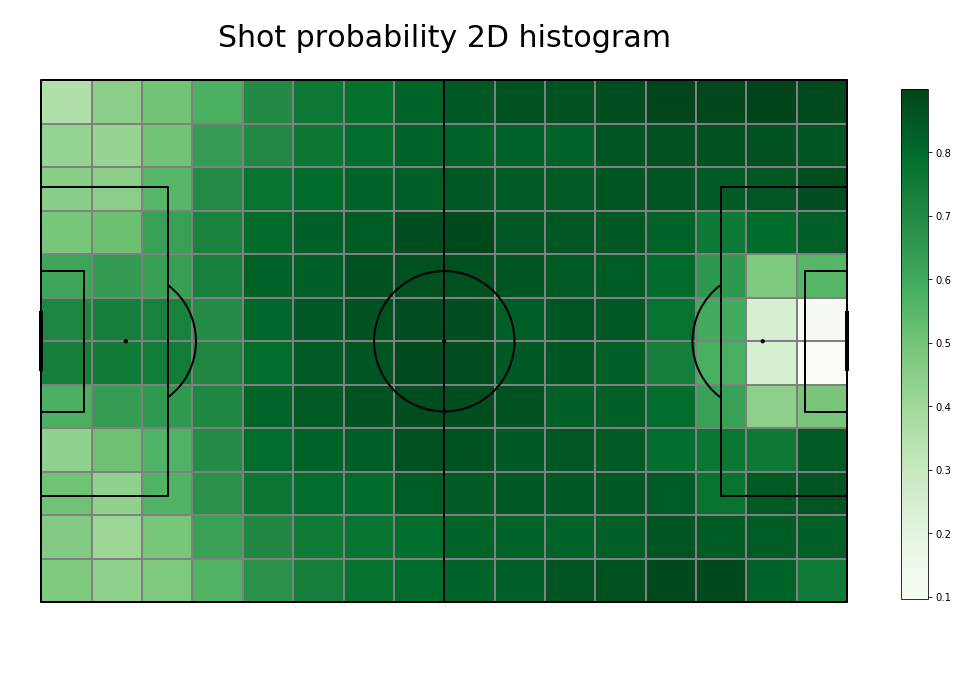

In [14]:
shot_probability = shot_count/(move_count+shot_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

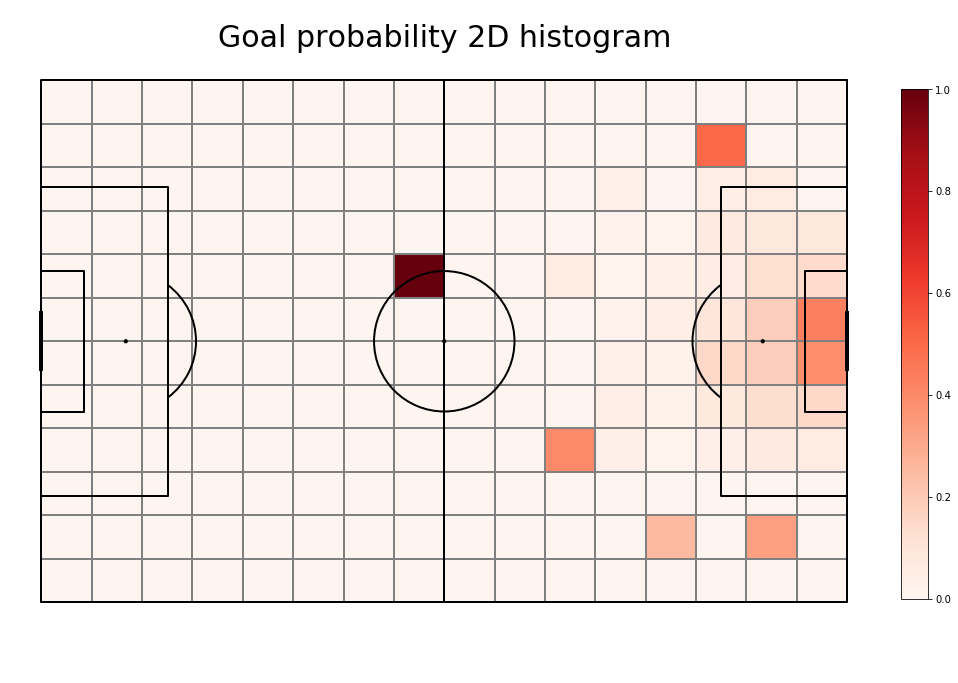

In [35]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

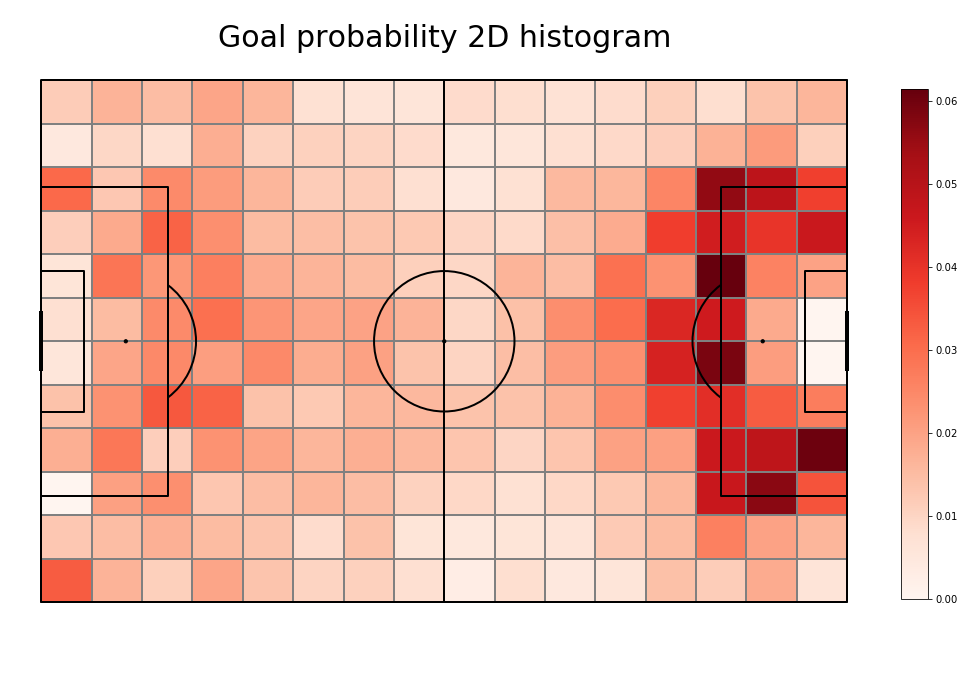

In [15]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

In [36]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

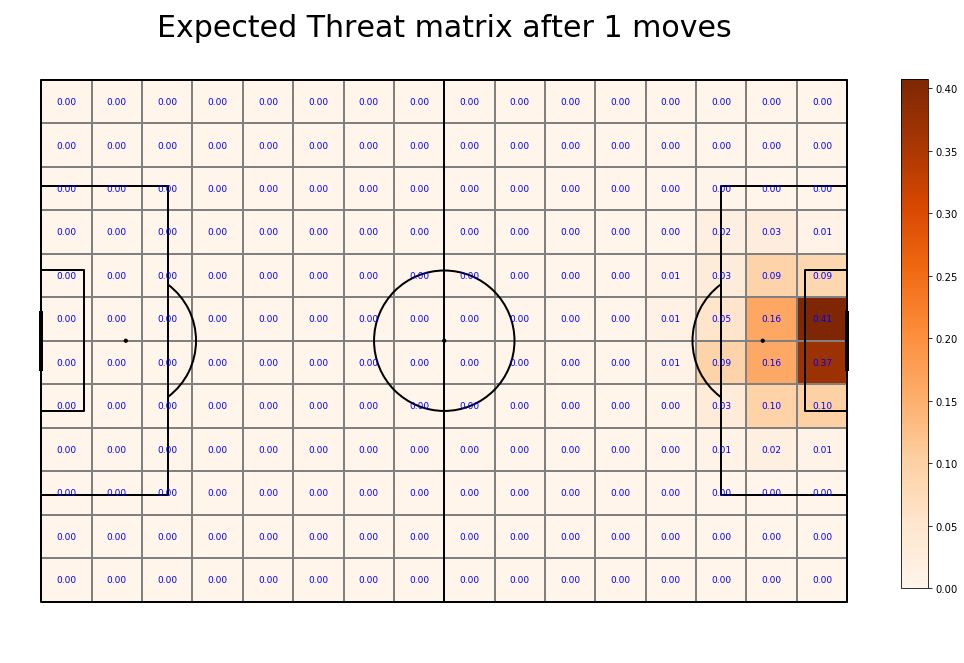

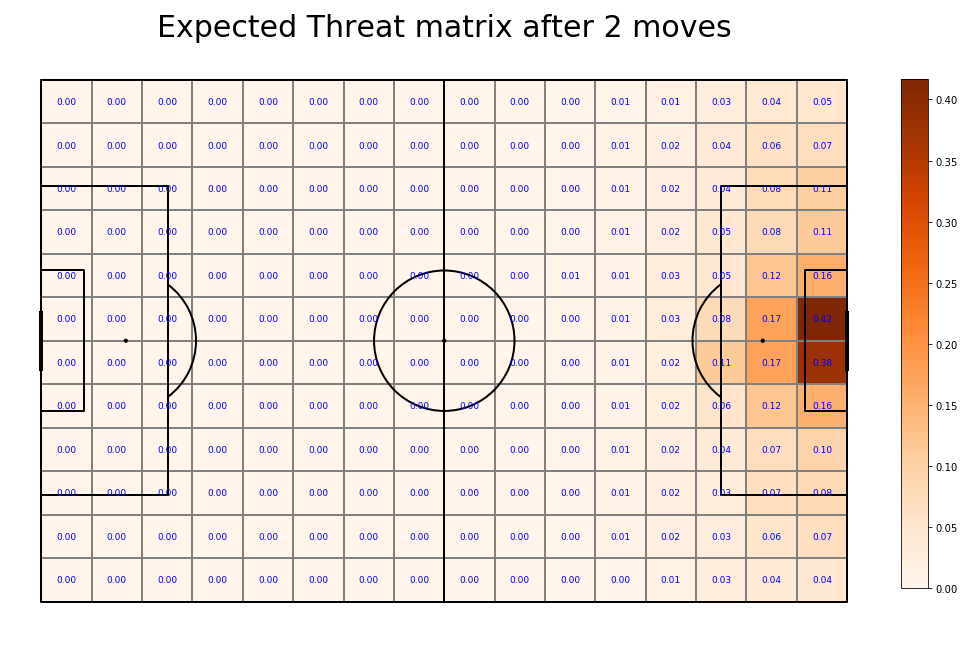

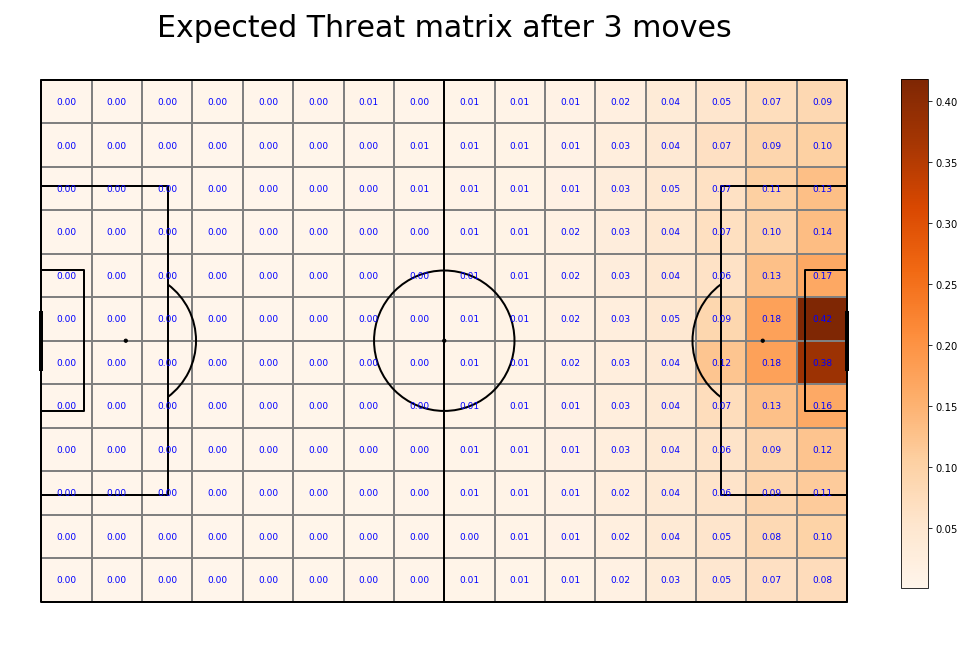

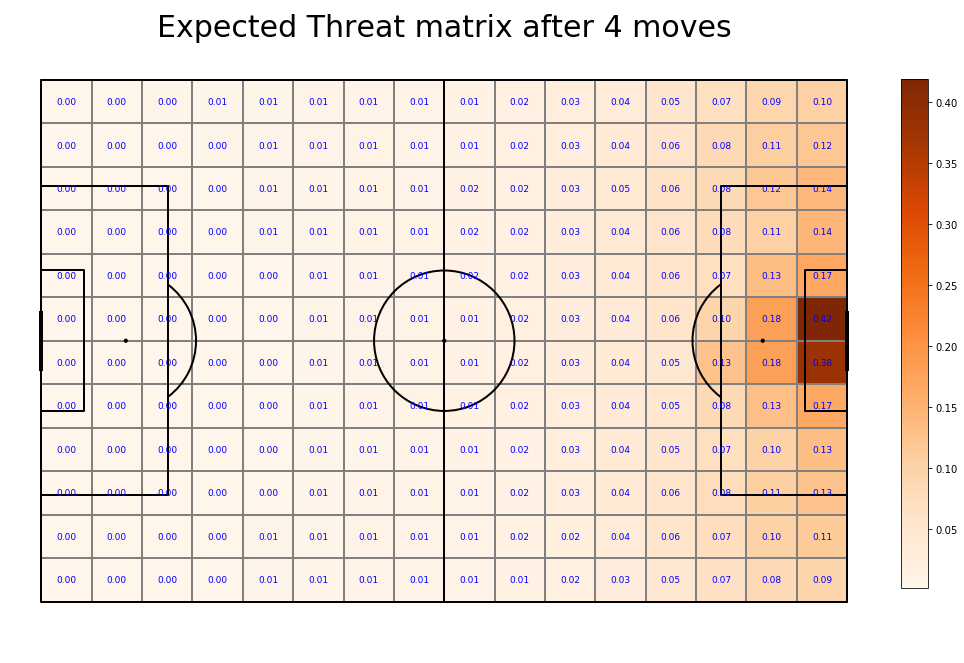

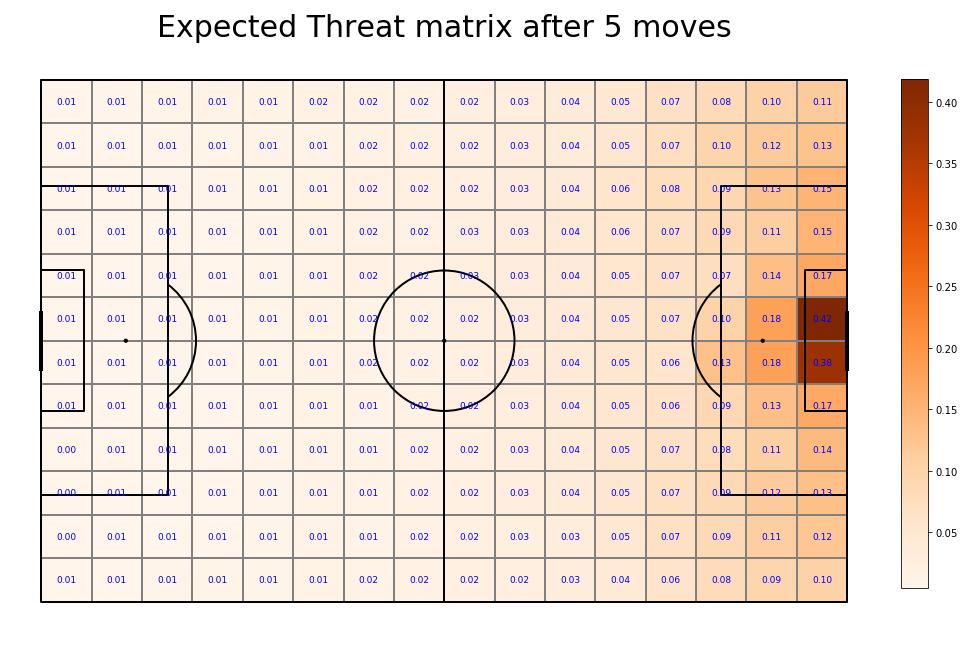

In [37]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [38]:
# intercepted middle 3rd passes
interceptions = move_df.loc[move_df.apply(lambda x:{'id':1802} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

# calculate potential xT
interceptions["xT_saved"] = interceptions.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1], axis = 1)

# only if possession changes
value_saving_actions = interceptions.loc[interceptions["teamId"] != interceptions["nextTeamId"]]

In [18]:
#only successful middle 3rd duels
successful_duels = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

#calculatexT
successful_duels["xT_added"] = successful_duels.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] , axis = 1)

#only progressive
value_adding_actions = successful_duels

In [39]:
#group by player
xT_saved_by_player = value_saving_actions.groupby(["nextPlayerId"])["xT_saved"].sum().reset_index()
xT_saved_by_player.rename(columns = {"nextPlayerId": "playerId"}, inplace = True)

In [19]:
#group by player
xT_added_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

In [40]:
xT_saved_by_player

,playerId,xT_saved
0,0,0.073360
1,36,0.597890
2,38,0.124090
3,48,2.539814
4,54,1.463606
...,...,...
459,447379,0.214779
460,447812,0.138980
461,448708,0.036792
462,486252,0.364741


In [20]:
xT_added_by_player

,playerId,xT_added
0,0,22.974694
1,36,0.212948
2,38,0.087403
3,48,1.133592
4,54,0.701660
...,...,...
452,447254,0.013653
453,447379,0.102847
454,447812,0.089319
455,486252,0.138747


In [26]:
def calulatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Expected Goals for players during the season.

    """
    #very basic xG model based on
    shots = df.loc[df["eventName"] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    #calculate distance and angle
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    #if you ever encounter problems (like you have seen that model treats 0 as 1 and 1 as 0) while modelling - change the dependant variable to object
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)
        #headers have id = 403
    headers = shots.loc[shots.apply (lambda x:{'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle" , data=headers,
                               family=sm.families.Binomial()).fit()
    #non-headers
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle" , data=non_headers,
                               family=sm.families.Binomial()).fit()
    #assigning xG
    #headers
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance'] + b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)

    #non-headers
    b_nhead = nonheaders_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance'] + b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)

    if npxG == False:
        #find pens
        penalties = df.loc[df["subEventName"] == "Penalty"]
        #assign 0.8
        penalties = penalties.assign(xG = 0.8)
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    else:
        #concat, group and sum
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns = {"xG": "npxG"}, inplace = True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
    #group by player and sum

    return xG_sum

#making function
npxg = calulatexG(train, npxG = True)
#investigate structure
npxg.head(3)

,playerId,npxG
0,8717,22.014180
1,120353,17.215819
2,11066,14.144484


In [8]:
def FinalThird(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player.

    """
    df = df.copy()
    #need player who had received the ball
    df["nextPlayerId"] = df["playerId"].shift(-1)
    passes = df.loc[train["eventName"] == "Pass"].copy()
    #changing coordinates
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

    #get accurate passes
    accurate_passes = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    #get passes into final third
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]

    #passes into final third by player
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'}, inplace=True)

    #receptions of accurate passes in the final third
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', "nextPlayerId": "playerId"}, inplace=True)

    #outer join not to lose values
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

final_third = FinalThird(train)
#investigate structure
final_third.head(3)

,playerId,final_third_passes,final_third_receptions
0,36,186.0,83.0
1,38,62.0,66.0
2,48,392.0,188.0


In [7]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)

    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground attacking duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)

    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(train)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0


In [14]:
train.loc[train["subEventName"].isin(["Ground defending duel", "Ground loose ball duel"])]\
        .loc[train.apply (lambda x:{'id':703} in x.tags, axis = 1)]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
22,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",12829,"[{'y': 22, 'x': 67}, {'y': 15, 'x': 71}]",2499719,Duel,1631,1H,38.191874,13,177959205
49,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",3319,"[{'y': 94, 'x': 25}, {'y': 94, 'x': 18}]",2499719,Duel,1609,1H,147.633740,13,177959218
53,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",370224,"[{'y': 73, 'x': 11}, {'y': 73, 'x': 5}]",2499719,Duel,1609,1H,152.127886,12,177959221
79,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",14853,"[{'y': 5, 'x': 77}, {'y': 10, 'x': 92}]",2499719,Duel,1631,1H,233.745610,12,177959262
101,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 50, 'x': 53}, {'y': 53, 'x': 47}]",2499719,Duel,1631,1H,346.556014,12,177961224
...,...,...,...,...,...,...,...,...,...,...,...,...
642998,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",8313,"[{'y': 55, 'x': 64}, {'y': 42, 'x': 67}]",2500098,Duel,1633,2H,2101.485826,13,251596089
643039,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",0,"[{'y': 23, 'x': 25}, {'y': 6, 'x': 37}]",2500098,Duel,1623,2H,2343.251440,13,251596986
643065,1,Ground defending duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",265318,"[{'y': 10, 'x': 13}, {'y': 9, 'x': 11}]",2500098,Duel,1633,2H,2465.899608,12,251596105
643070,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",8245,"[{'y': 89, 'x': 30}, {'y': 96, 'x': 35}]",2500098,Duel,1623,2H,2511.544824,13,251596369


In [21]:
def wonDefMidDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won Ground loose ball duel and Ground defending duel for a player

    """
    #find ground duels won
    ground_def_duels = df.loc[df["subEventName"].isin(["Ground defending duel", "Ground loose ball duel"])]
    won_def_duels = ground_def_duels.loc[ground_def_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    #filter for middle 3rd duels
    won_def_duels["x"] = won_def_duels.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    won_def_duels["y"] = won_def_duels.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    won_def_mid_duels = won_def_duels.loc[(won_def_duels["x"] < 2*105/3) & (won_def_duels["x"] > 105/3)]
    
    #group and sum duels
    result =  won_def_mid_duels.groupby(["playerId"]).eventId.count().reset_index()
    result.rename(columns = {'eventId':'def_mid_duels_won'}, inplace=True)

    #outer join
    # def_duels_won = wgdef_player.merge(wglb_player, how = "outer", on = ["playerId"])
    return result

def_mid_duels = wonDefMidDuels(train)
#investigate structure
def_mid_duels.sort_values(by="def_mid_duels_won", ascending=False)

,playerId,def_mid_duels_won
0,0,1151
388,265366,82
281,31528,78
61,7899,71
279,28292,64
...,...,...
306,62344,1
152,8583,1
164,8745,1
186,9179,1


In [22]:
def midFouls(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    mid_fouls: dataframe
        dataframe with number of middle third fouls.

    """
    #get fouls
    fouls = df.loc[df["eventName"] == "Foul"]
    
    #filter for middle 3rd duels
    fouls["x"] = fouls.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    fouls["y"] = fouls.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    fouls = fouls.loc[(fouls["x"] < 2*105/3) & (fouls["x"] > 105/3)]

    #sum by player
    mid_fouls =  fouls.groupby(["playerId"]).eventId.count().reset_index()
    mid_fouls.rename(columns = {'eventId':'mid_fouls'}, inplace=True)

    return mid_fouls

mid_fouls = midFouls(train)
#investigate structure
mid_fouls.head()

,playerId,mid_fouls
0,0,34
1,36,3
2,38,3
3,48,10
4,54,7


In [23]:
mid_fouls.sort_values(by='mid_fouls', ascending=False)

,playerId,mid_fouls
328,127537,40
200,11152,35
131,8416,35
0,0,34
245,25571,34
...,...,...
326,120339,1
354,240559,1
372,274488,1
373,277002,1


In [24]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.

    """
    #get smart passes
    smart_passes = df.loc[df["subEventName"] == "Smart pass"]
    #find accurate
    smart_passes_made = smart_passes.loc[smart_passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]

    #sum by player
    sp_player =  smart_passes_made.groupby(["playerId"]).eventId.count().reset_index()
    sp_player.rename(columns = {'eventId':'smart_passes'}, inplace=True)

    return sp_player

smart_passes = smartPasses(train)
#investigate structure
smart_passes.head(3)

,playerId,smart_passes
0,36,1
1,38,1
2,48,3


In [18]:
def GoalsAssistsKeyPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    data: dataframe
        dataframe with number of (non-penalty) goals, assists and key passes.

    """
    #get goals
    shots = df.loc[df["subEventName"] == "Shot"]
    goals = shots.loc[shots.apply (lambda x:{'id':101} in x.tags, axis = 1)]
    #get assists
    passes = df.loc[df["eventName"] == "Pass"]
    assists = passes.loc[passes.apply (lambda x:{'id':301} in x.tags, axis = 1)]
    #get key passes
    key_passes = passes.loc[passes.apply (lambda x:{'id':302} in x.tags, axis = 1)]

    #goals by player
    g_player =  goals.groupby(["playerId"]).eventId.count().reset_index()
    g_player.rename(columns = {'eventId':'goals'}, inplace=True)

    #assists by player
    a_player =  assists.groupby(["playerId"]).eventId.count().reset_index()
    a_player.rename(columns = {'eventId':'assists'}, inplace=True)

    #key passes by player
    kp_player =  key_passes.groupby(["playerId"]).eventId.count().reset_index()
    kp_player.rename(columns = {'eventId':'key_passes'}, inplace=True)

    data = g_player.merge(a_player, how = "outer", on = ["playerId"]).merge(kp_player, how = "outer", on = ["playerId"])
    return data

gakp = GoalsAssistsKeyPasses(train)
#investigate structure
gakp.head(3)

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0


In [27]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'minutes_played_per_game_Italy.json')
minutes_per_game = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     minutes_per_game = json.load(f)
# minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
minutes.head(3)

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343


In [217]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])

summary = summary.merge(def_mid_duels, how="left", on=["playerId"])\
                .merge(mid_fouls, how="left", on=["playerId"])\
                .merge(xT_saved_by_player, how="left", on=["playerId"])\
                .merge(xT_added_by_player, how="left", on=["playerId"])\
                .merge(xT_duels, how="left", on=["playerId"])
summary = minutes.merge(summary, how="left", on=["playerId"])

summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
summary.head(3)

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT
0,36,1238,13.0,3.0,0.597890,0.212948,0.000432
2,48,3343,50.0,10.0,2.539814,1.133592,0.084824
3,54,3348,33.0,7.0,1.463606,0.701660,0.065903


In [42]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 512
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playerId           397 non-null    int64  
 1   minutesPlayed      397 non-null    int64  
 2   npxG               397 non-null    float64
 3   def_mid_duels_won  397 non-null    float64
 4   mid_fouls          397 non-null    float64
 5   xT_saved           397 non-null    float64
 6   xT_added           397 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 24.8 KB


In [221]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     players = json.load(f).encode('utf8')
# player_df = pd.DataFrame(players)

In [222]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   passportArea           3603 non-null   object
 1   weight                 3603 non-null   int64 
 2   firstName              3603 non-null   object
 3   middleName             3603 non-null   object
 4   lastName               3603 non-null   object
 5   currentTeamId          3512 non-null   object
 6   birthDate              3603 non-null   object
 7   height                 3603 non-null   int64 
 8   role                   3603 non-null   object
 9   birthArea              3603 non-null   object
 10  wyId                   3603 non-null   int64 
 11  foot                   3603 non-null   object
 12  shortName              3603 non-null   object
 13  currentNationalTeamId  3603 non-null   object
dtypes: int64(3), object(11)
memory usage: 394.2+ KB


In [223]:
player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis=1)].head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712
10,"{'name': 'Austria', 'id': '40', 'alpha3code': ...",74,Marcel,,Sabitzer,2975,1994-03-17,177,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Austria', 'id': '40', 'alpha3code': ...",65596,right,M. Sabitzer,null
15,"{'name': 'Iceland', 'id': '352', 'alpha3code':...",77,Johann,,Berg Guðmunds­son,1646,1990-10-27,186,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Iceland', 'id': '352', 'alpha3code':...",93,left,J. Guðmunds­son,7839
20,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",78,Kevin,,Strootman,3158,1990-02-13,186,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",114,left,K. Strootman,null


In [224]:
midfielders = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis = 1)]
midfielders.rename(columns = {'wyId':'playerId'}, inplace=True)

to_merge = midfielders[['playerId', 'shortName']]
summary = summary.merge(to_merge, how="inner", on=["playerId"])
summary.head(3)

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName
0,54,3348,33.0,7.0,1.463606,0.701660,0.065903,C. Eriksen
1,93,2942,26.0,7.0,1.116842,0.404005,0.034647,J. Guðmunds­son
2,116,2495,30.0,11.0,1.317382,0.719863,-0.192037,G. Wijnaldum


In [225]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 148
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playerId           149 non-null    int64  
 1   minutesPlayed      149 non-null    int64  
 2   def_mid_duels_won  149 non-null    float64
 3   mid_fouls          149 non-null    float64
 4   xT_saved           149 non-null    float64
 5   xT_added           149 non-null    float64
 6   xT                 149 non-null    float64
 7   shortName          149 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 10.5+ KB


In [226]:
summary[summary.playerId.isin([265366, 31528, 7899, 28292, 127537])]

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName
17,7899,3030,71.0,33.0,2.608227,1.459828,0.093799,Oriol Romeu
88,28292,3498,64.0,21.0,2.623032,1.290039,0.230457,A. Doucouré
90,31528,3119,78.0,21.0,2.495378,1.521925,0.165069,N. Kanté
117,127537,3217,51.0,40.0,3.143859,1.085988,0.147569,L. Milivojević
134,265366,3028,82.0,33.0,2.735931,1.606991,0.246927,W. Ndidi


In [49]:
minutes_per_game.head(3)

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,9206,C. Wood,2500089,1646,Burnley FC,0,61,61,0
1,9127,S. Vokes,2500089,1646,Burnley FC,61,95,34,0
2,93,J. Guðmunds­son,2500089,1646,Burnley FC,0,80,80,0


In [50]:
minutes_per_game.loc[minutes_per_game['teamName']=='Chelsea FC']['shortName'].unique()

array(['O. Giroud', 'Álvaro Morata', 'R. Barkley', 'Willian', 'E. Hazard',
       'Pedro', 'V. Moses', 'Emerson', 'A. Christensen', 'Azpilicueta',
       'N. Kanté', 'T. Bakayoko', 'G. Cahill', 'T. Courtois',
       'D. Zappacosta', 'W. Caballero', 'Fàbregas', 'Marcos Alonso',
       'A. Rüdiger', 'C. Hudson-Odoi', 'D. Drinkwater', 'David Luiz',
       'C. Musonda', 'M. Batshuayi', 'E. Ampadu', 'J. Boga'], dtype=object)

In [122]:
possession_dict = {}

#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] = (match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] 
                                                                + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1])
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"]\
                                    .isin(["Air duel", "Ground defending duel","Ground loose ball duel"])]\
                                        .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possession_dict[str(player_id)]["team_passes"] += len(team_passes)
    possession_dict[str(player_id)]["all_passes"] += len(all_passes)

In [227]:
possession_dict

{'9206': {'team_passes': 8653, 'all_passes': 19358},
 '9127': {'team_passes': 5097, 'all_passes': 11610},
 '93': {'team_passes': 14957, 'all_passes': 34126},
 '9179': {'team_passes': 378, 'all_passes': 802},
 '10108': {'team_passes': 7420, 'all_passes': 17123},
 '8433': {'team_passes': 13085, 'all_passes': 29551},
 '8125': {'team_passes': 18037, 'all_passes': 41079},
 '9433': {'team_passes': 14990, 'all_passes': 33575},
 '8980': {'team_passes': 12531, 'all_passes': 28448},
 '8643': {'team_passes': 12072, 'all_passes': 27557},
 '12242': {'team_passes': 16477, 'all_passes': 37717},
 '8925': {'team_passes': 6097, 'all_passes': 13405},
 '8284': {'team_passes': 10414, 'all_passes': 23634},
 '532949': {'team_passes': 2, 'all_passes': 2},
 '259531': {'team_passes': 361, 'all_passes': 717},
 '7989': {'team_passes': 11513, 'all_passes': 25268},
 '245813': {'team_passes': 3784, 'all_passes': 7733},
 '11669': {'team_passes': 12107, 'all_passes': 25264},
 '239411': {'team_passes': 986, 'all_passes

In [124]:
#calculate possession for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}

#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possession"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)

In [54]:
#calculate per 100 opposition touches possession for each player
percentage_dict = {key: ((value["all_passes"]-value["team_passes"]))
                   if (value["all_passes"]-value["team_passes"]) > 0 else 0 for key, value in possession_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "oppTouches"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)

In [228]:
#merge it
summary = summary.merge(percentage_df, how="left", on=["playerId"])

In [145]:
percentage_df.head(3)

,playerId,possession
0,9206,0.446999
1,9127,0.439018
2,93,0.438288


In [229]:
summary.head()

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName,possession
0,54,3348,33.0,7.0,1.463606,0.701660,0.065903,C. Eriksen,0.606674
1,93,2942,26.0,7.0,1.116842,0.404005,0.034647,J. Guðmunds­son,0.438288
2,116,2495,30.0,11.0,1.317382,0.719863,-0.192037,G. Wijnaldum,0.576787
3,173,2211,26.0,12.0,0.666220,0.490654,0.044516,R. van La Parra,0.478545
4,179,671,2.0,2.0,0.179772,0.096885,-0.004543,L. Narsingh,0.494446


In [230]:
summary.sort_values(by='xT', ascending=False)

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName,possession
134,265366,3028,82.0,33.0,2.735931,1.606991,0.246927,W. Ndidi,0.474780
88,28292,3498,64.0,21.0,2.623032,1.290039,0.230457,A. Doucouré,0.491539
46,8471,3233,24.0,3.0,0.913929,0.402178,0.230301,A. Townsend,0.456740
9,3350,2408,39.0,15.0,0.884433,0.626479,0.222535,Fàbregas,0.548264
72,13484,3055,42.0,15.0,0.741273,0.543486,0.216351,D. Alli,0.597120
...,...,...,...,...,...,...,...,...,...
8,3319,2253,17.0,7.0,0.371013,0.211744,-0.004909,M. Özil,0.603388
136,279717,967,12.0,3.0,0.462767,0.210037,-0.010681,A. Maitland-Niles,0.587015
28,8013,2644,34.0,5.0,1.029142,0.523430,-0.014090,M. Albrighton,0.483735
81,25706,2860,60.0,31.0,2.697511,1.120675,-0.015200,I. Gueye,0.464590


In [231]:
summary.loc[summary['shortName'].isin(['N. Kanté', 'T. Bakayoko', 'Fàbregas', 'D. Drinkwater'])]

,playerId,minutesPlayed,def_mid_duels_won,mid_fouls,xT_saved,xT_added,xT,shortName,possession
9,3350,2408,39.0,15.0,0.884433,0.626479,0.222535,Fàbregas,0.548264
47,8495,557,7.0,8.0,0.289750,0.153650,0.021496,D. Drinkwater,0.504436
87,28291,2216,39.0,24.0,1.263259,0.755384,0.159985,T. Bakayoko,0.542455
90,31528,3119,78.0,21.0,2.495378,1.521925,0.165069,N. Kanté,0.557114


In [149]:
summary.columns

Index(['playerId', 'minutesPlayed', 'npxG', 'def_mid_duels_won', 'mid_fouls',
       'xT_saved', 'xT_added', 'shortName', 'oppTouches', 'possession'],
      dtype='object')

In [235]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]

summary = summary[[
    'playerId', 'minutesPlayed',
    # 'npxG', 
    # "goals", 
    # "assists", "key_passes", 
    # "smart_passes_adjusted_per90",
    # "final_third_passes", "final_third_receptions",
    "def_mid_duels_won", "mid_fouls",
    "xT_saved", "xT_added", "xT",
    'shortName', 'possession'
]]
    # "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]

min_range = []
max_range = []
#calculate value adjusted
for column in summary.columns[2:7]:
    # (1000/x["oppTouches"])
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possession"] * (90/x["minutesPlayed"])), axis = 1)
    # summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column] * (1000/x["oppTouches"])), axis = 1) 
    min_range.append(summary_adjusted[column + "_adjusted_per90"].min())
    max_range.append(summary_adjusted[column + "_adjusted_per90"].max())    

In [236]:
summary_adjusted.head()

,shortName,def_mid_duels_won_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_adjusted_per90
0,C. Eriksen,1.462230,0.310170,0.064852,0.031091,0.002920
1,J. Guðmunds­son,1.814739,0.488583,0.077953,0.028199,0.002418
2,G. Wijnaldum,1.876193,0.687938,0.082389,0.045020,-0.012010
3,R. van La Parra,2.211588,1.020733,0.056669,0.041736,0.003787
4,L. Narsingh,0.542539,0.542539,0.048767,0.026282,-0.001232


In [264]:
#player to investigate - Kanté
#only his statistics
# player_name = "T. Bakayoko"
# player_name = "N. Kanté"
player_name = "Fàbregas"

player_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == player_name]

#columns similar together
# kante_adjusted = kante_adjusted[[
#     'npxG_adjusted_per90', "goals_adjusted_per90", 
#     "assists_adjusted_per90", "key_passes_adjusted_per90", 
#     # "smart_passes_adjusted_per90",
#     "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90",
#     "def_mid_duels_won_adjusted_per90", "mid_fouls_adjusted_per90"]]
#     # "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]

#take only necessary columns - exclude playerId
adjusted_columns = player_adjusted.columns[1:8]

#values to mark on the plot
values = [round(player_adjusted[column].iloc[0],2) for column in adjusted_columns]

#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], player_adjusted[column].iloc[0])) for column in adjusted_columns]

In [265]:
player_adjusted

,shortName,def_mid_duels_won_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_adjusted_per90
9,Fàbregas,2.658649,1.022557,0.060292,0.042707,0.01517


In [266]:
values

[2.66, 1.02, 0.06, 0.04, 0.02]

In [267]:
percentiles

[62, 46, 25, 44, 95]

In [268]:
percentiles[1] = 100 - percentiles[1]

In [269]:
percentiles

[62, 54, 25, 44, 95]

In [249]:
summary_adjusted['def_mid_duels_won_adjusted_per90'].min()

0.5425393608981093

In [250]:
summary_adjusted['def_mid_duels_won_adjusted_per90'].max()

7.2535319618451295

In [251]:
summary_adjusted['mid_fouls_adjusted_per90'].min()

0.08877976708707273

In [252]:
summary_adjusted['mid_fouls_adjusted_per90'].max()

3.2920393394942122

In [253]:
min_range

[0.5425393608981093,
 0.08877976708707273,
 0.013924745943112557,
 0.013870995655112114,
 -0.012009960330194738]

In [254]:
max_range

[7.2535319618451295,
 3.2920393394942122,
 0.24557861687667734,
 0.1291692947509184,
 0.02508409492345741]

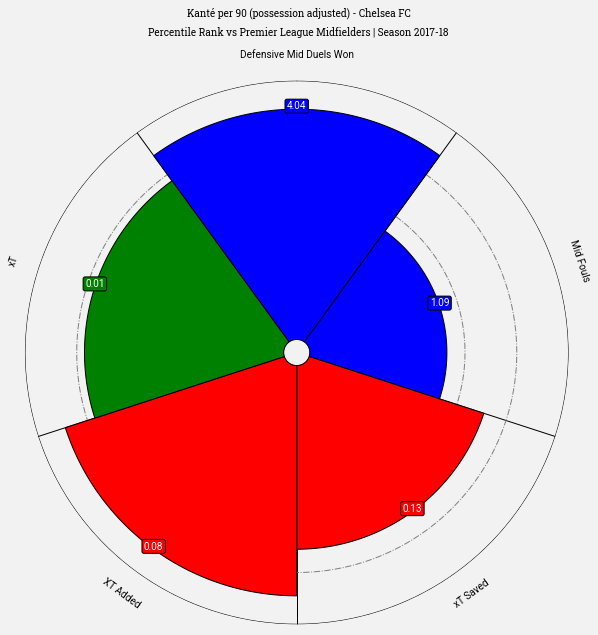

In [255]:
names = [
    # "non-penalty Expected Goals", 
    # "non-penalty Goals", 
    # "Assists", "Key Passes", 
    # "Smart Passes", 
    # "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Defensive Mid Duels Won", "Mid Fouls",
    "xT Saved", "XT Added", "xT"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    # min_range=min_range,
    # max_range=max_range,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["red"] * 2 + ["green"] * 1  
text_colors = ["white"]*5
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Kanté per 90 (possession adjusted) - Chelsea FC", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()

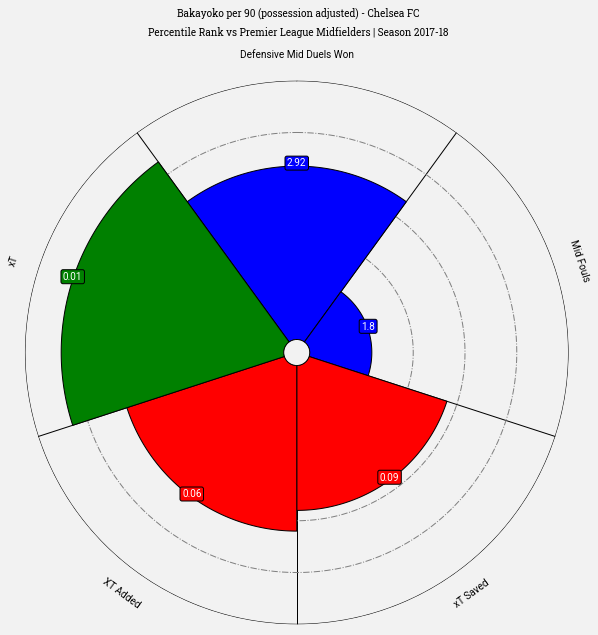

In [263]:
names = [
    # "non-penalty Expected Goals", 
    # "non-penalty Goals", 
    # "Assists", "Key Passes", 
    # "Smart Passes", 
    # "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Defensive Mid Duels Won", "Mid Fouls",
    "xT Saved", "XT Added", "xT"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    # min_range=min_range,
    # max_range=max_range,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["red"] * 2 + ["green"] * 1  
text_colors = ["white"]*5
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Bakayoko per 90 (possession adjusted) - Chelsea FC", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()

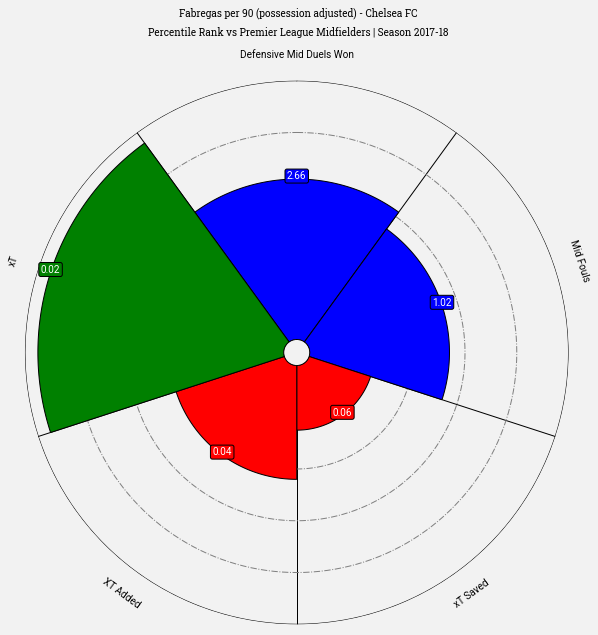

In [270]:
names = [
    # "non-penalty Expected Goals", 
    # "non-penalty Goals", 
    # "Assists", "Key Passes", 
    # "Smart Passes", 
    # "Passes Ending in Final Third", "Passes Received in Final Third", 
    "Defensive Mid Duels Won", "Mid Fouls",
    "xT Saved", "XT Added", "xT"]
    # "Offensive Ground Duels Won", "Air Duels Won"]
baker = PyPizza(
    params=names,                   # list of parameters
    # min_range=min_range,
    # max_range=max_range,
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

slice_colors = ["blue"] * 2 + ["red"] * 2 + ["green"] * 1  
text_colors = ["white"]*5
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))
fig, ax = baker.make_pizza(
    percentiles,          # list of values: either the raw metric values or the percentile values can be chosen to plot
    figsize=(10,10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    # values to be used when plotting slices
    kwargs_slices=dict(
        facecolor="cornflowerblue", 
        edgecolor="#000000", 
        zorder=2, 
        linewidth=1),
    # values to be used when adding parameter
    kwargs_params=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        va="center"), 
    # values to be used when adding parameter-values
    kwargs_values=dict(
        color="#000000", 
        fontsize=12, 
        fontproperties=font_normal.prop, 
        zorder=3,
        bbox=dict(
            edgecolor="#000000", 
            facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", 
            lw=1
        )
    )
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))

# add title
fig.text(
    0.515, 
    0.97, 
    "Fabregas per 90 (possession adjusted) - Chelsea FC", 
    size=18,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

# add subtitle
fig.text(
    0.515, 
    0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", 
    fontproperties=font_bold.prop, 
    color="#000000"
)

plt.show()